# Compare Methods for Fitting Measurements from Experiment `20211202_72bar`

Note that the thresholds for analysis were determined based on `bubbletracking_koe/analysis/true_obj_vs_threshold.py`

In [7]:
%load_ext autoreload
%autoreload 2

# sets plotting font to Arial
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

# standard libraries
import os
import glob
import pickle as pkl

# 3rd party libraries
import numpy as np
import matplotlib.pyplot as plt

# custom libraries
import sys
sys.path.append('../../libs/')
import fn
import flow
import plot.bubble as pltb
from conversions import *

# comes after imports from ../../libs/ because I unfortunately 
# created files with the same name there and in ../src/
sys.path.append('../src/')
import objproc as op
import bubble
import analytics as an

### PARAMETERS ###
# directory template containing data files
data_dir_tmp = '../input/ppg_co2/20211202_72bar/*'
# data filename
data_filename = 'data.pkl'
# data for polyol-CO2 mixture 
# make this on Wang group server with `bi_surf`--read README.txt and copy 1k3f_22c.csv
polyol_data_file = '../input/3k2f_31c.csv'
# equation of state data for CO2 at desired temperature 
eos_co2_file = '../input/eos_co2_25-0C.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plot Bubble Growth

Just until they start to elongate.

I plot the radius instead of the length or width because the length and width are discrete due to pixellation, whereas the fact that the radius is computed from the length and width allows it to take on more values and appear less discrete.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


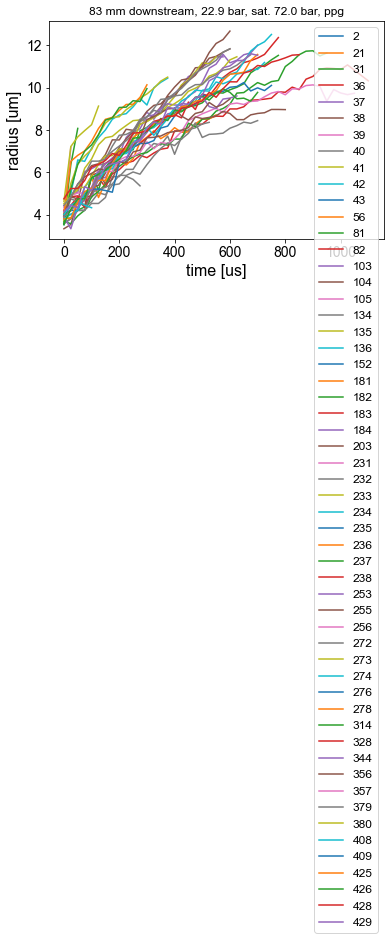

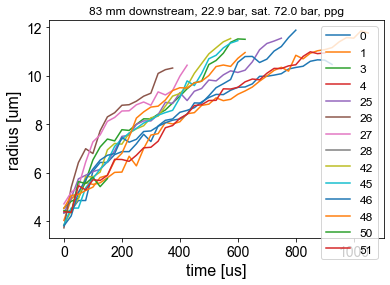

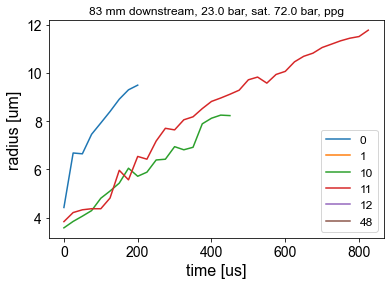

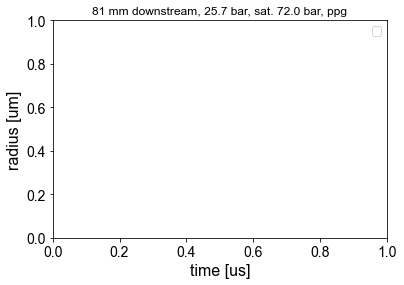

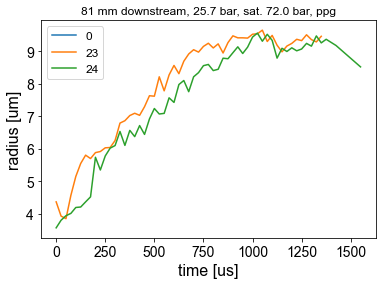

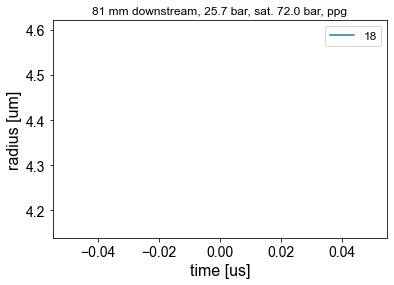

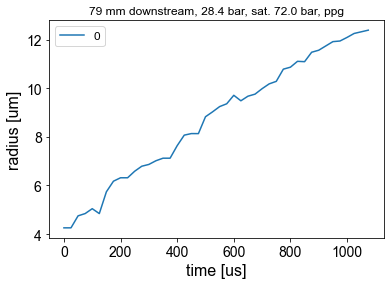

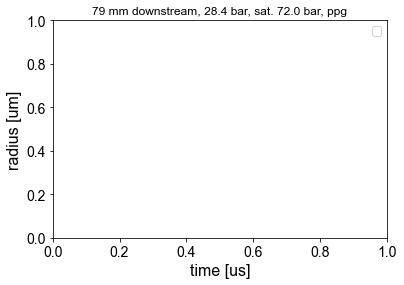

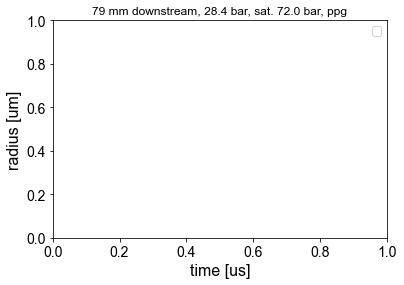

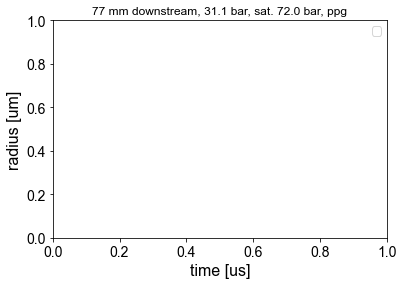

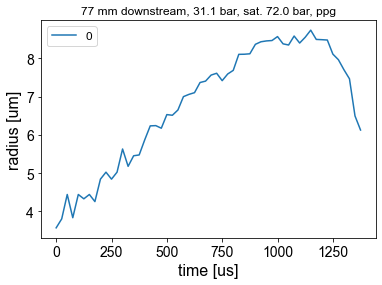

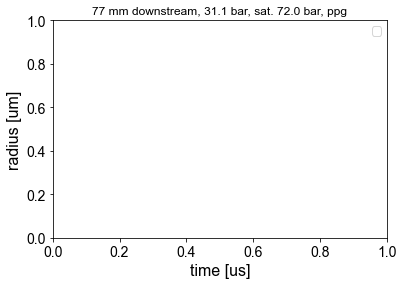

In [9]:
# plot parameters
ax_fs = 16
tk_fs = 14
l_fs = 12


# data structs to store bubble radii, etc.
# keys will be (num, ID), where num is video number and ID is bubble ID number
# values will be dictionaries of properties: time [s], radius [m], width [m], length [m],
bubble_growth = {}

# loads data from each file
data_dir_list = glob.glob(data_dir_tmp)
for data_dir in data_dir_list:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    with open(os.path.join(data_dir, data_filename), 'rb') as f:
        data = pkl.load(f)
        
    # gets conditions of measurement
    p_in, p_sat, p_est, p_in, d, L, v_max, t_center, polyol = op.get_conditions(data['metadata'])

    # gets sizes of each bubble
    for ID, obj in data['objects'].items():
        # skips objects that are not definitely real objects (bubbles)
        if not op.is_true_obj(obj):
            continue
        
        # calculates time and radius of object
        t = op.calc_t(obj, d, v_max)  
        t -= t[0] # shifts so starts at t = 0
        R = np.asarray(obj['props_proc']['radius [um]'])
        
        # gets indices of frames where object is in early growth stages
        idx = op.get_valid_idx(obj)
        
        # plots bubble growth
        ax.plot(t[idx]*s_2_us, R[idx], label=str(ID))
        
        
    # formats plot
    ax.set_xlabel('time [us]', fontsize=ax_fs)
    ax.set_ylabel('radius [um]', fontsize=ax_fs)
    ax.tick_params(axis='both', labelsize=tk_fs)
    ax.legend(fontsize=l_fs)
    ax.set_title('{0:d} mm downstream, {1:.1f} bar, sat. {2:.1f} bar, {3:s}'\
                 .format(int(d*m_2_mm), p_est*Pa_2_bar, p_sat*Pa_2_bar, polyol))

## Fit Growth to Multiple Points

In [ ]:
# GROWTH MODEL PARAMETERS
growth_fn = bubble.grow
dt = 1E-10 # [s]
R_nuc = 3E-9 # higher value bypasses numerical challenges at nm scale [m]
# make this on Wang group server with `bi_surf`--read README.txt and copy 1k3f_22c.csv
polyol_data_file = '../input/3k2f_31c.csv'
# equation of state data for CO2 at desired temperature 
eos_co2_file = '../input/eos_co2_25-0C.csv'

# FITTING PARAMETERS
frac_lo = 0.95
frac_hi = 1.05
# guess for effective diffusivity constant [m^2/s]
D_lo = 1E-9
D_hi = 8E-9
fit_fn_params = {'err_tol' : 0.003, 'err_fn' : an.calc_abs_sgn_mse}
exp_ratio_tol = 0.01

# PLOTTING PARAMETERS
x_lim = [1E-2, 10]
y_lim = [1, 30]

# USER PARAMETERS
n_fit = 5

# globs list of data directories
data_dir_list = glob.glob(data_dir_tmp)

growth_data_dict = {}

# error tolerances
rms_err_tol = 0.03
sgn_mse_err_tol = 0.003

options = {'single pt' : {'fit_fn' : an.fit_growth_to_pt, 'fit_fn_params': {}},
          'rms' : {'fit_fn' : an.fit_growth_to_pts, 'fit_fn_params' : 
                   {'err_fn' : an.calc_rms_err, 'err_tol' : rms_err_tol}},
          'sgn mse' : {'fit_fn' : an.fit_growth_to_pts, 'fit_fn_params' :
                      {'err_fn' : an.calc_abs_sgn_mse, 'err_tol' : sgn_mse_err_tol}}
          }

for tag in options.keys():
    print('\n\nBeginning analysis for {0:s}.\n\n'.format(tag))
    params = options[tag]
    # fits effective diffusivity D and nucleation time t_nuc
    growth_data = an.fit_D_t_nuc(data_filename, data_dir_list, polyol_data_file, eos_co2_file,
                                 frac_lo, frac_hi, D_lo, D_hi, growth_fn, dt, R_nuc, 
                                 params['fit_fn_params'], exp_ratio_tol, fit_fn=params['fit_fn'],
                                 n_fit=n_fit, x_lim=x_lim, y_lim=y_lim)
    
    # stores results under tag
    growth_data_dict[tag] = growth_data



Beginning analysis for single pt.


t_nuc = 96.501 ms and error in R is 0.9992.
t_nuc = 94.088 ms and error in R is 1.9532.
t_nuc = 95.294 ms and error in R is 1.1294.
t_nuc = 95.897 ms and error in R is 0.4751.
t_nuc = 96.199 ms and error in R is 0.0600.
t_nuc = 96.048 ms and error in R is 0.2385.
t_nuc = 96.124 ms and error in R is 0.1044.
t_nuc = 96.161 ms and error in R is 0.0210.
t_nuc = 96.180 ms and error in R is 0.0226.
t_nuc = 96.171 ms and error in R is 0.0041.
Error in bubble radius is below tolerance of 0.0100 for nucleation time t = 96.171 ms
For D = 4.5e-09, exponent ratio = 0.950
t_nuc = 96.501 ms and error in R is 0.9992.
t_nuc = 94.088 ms and error in R is 2.5103.
t_nuc = 95.294 ms and error in R is 1.5337.
t_nuc = 95.897 ms and error in R is 0.7301.
t_nuc = 96.199 ms and error in R is 0.1296.
t_nuc = 96.350 ms and error in R is 0.4090.
t_nuc = 96.274 ms and error in R is 0.0969.
t_nuc = 96.237 ms and error in R is 0.0018.
Error in bubble radius is below tolerance of

t_nuc = 95.332 ms and error in R is 0.0738.
t_nuc = 95.351 ms and error in R is 0.0298.
t_nuc = 95.360 ms and error in R is 0.0233.
t_nuc = 95.365 ms and error in R is 0.0079.
Error in bubble radius is below tolerance of 0.0100 for nucleation time t = 95.365 ms
For D = 7.97266e-09, exponent ratio = 0.818
t_nuc = 96.501 ms and error in R is 0.9993.
t_nuc = 94.088 ms and error in R is 1.7118.
t_nuc = 95.294 ms and error in R is 0.1774.
t_nuc = 95.897 ms and error in R is 0.9993.
t_nuc = 95.596 ms and error in R is 0.9993.
t_nuc = 95.445 ms and error in R is 0.2508.
t_nuc = 95.370 ms and error in R is 0.0317.
t_nuc = 95.332 ms and error in R is 0.0747.
t_nuc = 95.351 ms and error in R is 0.0236.
t_nuc = 95.360 ms and error in R is 0.0242.
t_nuc = 95.365 ms and error in R is 0.0070.
Error in bubble radius is below tolerance of 0.0100 for nucleation time t = 95.365 ms
For D = 7.98633e-09, exponent ratio = 0.818
t_nuc = 96.501 ms and error in R is 0.9993.
t_nuc = 94.088 ms and error in R is 

t_nuc = 94.088 ms and error in R is 2.4857.
t_nuc = 95.294 ms and error in R is 0.2772.
t_nuc = 95.897 ms and error in R is 0.9991.
t_nuc = 95.596 ms and error in R is 0.9991.
t_nuc = 95.445 ms and error in R is 0.4928.
t_nuc = 95.370 ms and error in R is 0.0069.
Error in bubble radius is below tolerance of 0.0100 for nucleation time t = 95.370 ms
For D = 7.89063e-09, exponent ratio = 0.880
t_nuc = 96.501 ms and error in R is 0.9991.
t_nuc = 94.088 ms and error in R is 2.5016.
t_nuc = 95.294 ms and error in R is 0.2816.
t_nuc = 95.897 ms and error in R is 0.9991.
t_nuc = 95.596 ms and error in R is 0.9991.
t_nuc = 95.445 ms and error in R is 0.4910.
t_nuc = 95.370 ms and error in R is 0.0034.
Error in bubble radius is below tolerance of 0.0100 for nucleation time t = 95.370 ms
For D = 7.94531e-09, exponent ratio = 0.880
t_nuc = 96.501 ms and error in R is 0.9991.
t_nuc = 94.088 ms and error in R is 2.5077.
t_nuc = 95.294 ms and error in R is 0.2839.
t_nuc = 95.897 ms and error in R is 

## Compare Result for Different Error Functions

Assuming that the result converges, I want to compare the finally RMS error between the prediction and the measurement.

In [ ]:
tag_list = list(growth_data_dict.keys())
d_list = growth_data_dict[tag_list[0]].keys()

for d in d_list:
    vid_data_list = [growth_data_dict[tag][d] for tag in tag_list]
    for ID in vid_data_list[0].keys():
        bub_data_list = [vid_data[ID] for vid_data in vid_data_list]
        # computes RMS error for each fit method
        rms_list = [an.calc_rms_fit(bub_data) for bub_data in bub_data_list]
        
        print('Compare RMS for bubble {0:d}'.format(ID))
        print(*zip(tag_list, rms_list))
    